In [1]:
%pylab inline
import sympy
sympy.init_printing()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def array_to_poly(a, s):
    n = len(a)
    p = 0
    for i, c in enumerate(a):
        p += c*s**(n - i - 1)
    return p
        
def TransferFunction(num , den):
    s = sympy.Symbol('s')
    return array_to_poly(num, s)/ array_to_poly(den, s)

class StateSpace(object):
    def __init__(self, A, B, C, D, dt):
        self.A = sympy.Matrix(A)
        self.B = sympy.Matrix(B)
        self.C = sympy.Matrix(C)
        self.D = sympy.Matrix(D)
        self.dt = dt

    def __str__(self):
        return '''StateSpace(\nA={:s},\nB={:s},\nC={:s},\nD={:s},\ndt={:s})
        '''.format(
            repr(self.A),
            repr(self.B),
            repr(self.C),
            repr(self.D),
            repr(self.dt))

    __repr__ = __str__
    
    def simplify(self):
        self.A.simplify()
        self.B.simplify()
        self.C.simplify()
        self.D.simplify()

def ss2tf(ss):
    s = sympy.Symbol('s')
    n = ss.A.shape[0]
    I = sympy.eye(n)
    G = (ss.C*(s*I - ss.A).inv()*ss.B + ss.D)
    G.simplify()
    return G

In [3]:
def controllable_canonical_form(G):
    b = sympy.poly(sympy.numer(G)).coeffs()
    a = sympy.poly(sympy.denom(G)).coeffs()
    assert len(b) <= len(a)
    n = len(a)
    
    A = sympy.zeros(n)
    for j in range(n):
        for i in range(n):
            if j == i + 1:
                A[i, j] = 1
        A[n - 1, j] = a[j]
        
    B = sympy.zeros(n, 1)
    B[n-1, 0] = 1
    
    C = sympy.Matrix([b[n-i-1] - a[n-i-1]*b[0] for i in range(0, n)]).T
    D = sympy.Matrix([b[0]])
    return StateSpace(A, B, C, D, 0)

In [4]:
def similarity_transformation(ss, T):
    ssJ = StateSpace(
        T.inv()*ss.A*T,
        T.inv()*ss.B,
        ss.C*T,
        ss.D, ss.dt)
    ssJ.simplify()
    return ssJ

In [5]:
def jordan_canonical_form(ss):
    eigen_vects = ss.A.eigenvects()
    T = None
    for val, mult, basis in ss.A.eigenvects():
        if mult != 1:
            raise NotImplemented('only eigenvalues of multiplicity 1 are currently supported')
        if T is None:
            T = basis[0]
        else:
            T = T.row_join(basis[0])
    T.simplify()
    return similarity_transformation(ss, T), T

In [6]:
def tf2ss(G):
    if not hasattr(G, 'shape'):
        G = sympy.Matrix([G])
    s = sympy.Symbol('s')
    # find unique roots
    roots = []
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            for t in G[i,j].apart(s).as_ordered_terms():
                for root in sympy.roots(sympy.denom(t), s):
                    if root not in roots:
                        roots += [root]

    
    n = len(roots)
    m = G.shape[0]
    p = G.shape[1]
    A = sympy.zeros(n)
    C = None
    B = None
    D = G.applyfunc(lambda x: x.apart(s).limit(s, inf))

    # for each root
    for i_root, root in enumerate(roots):

        # create a from root
        A[i_root, i_root ] = root

        # find residue
        G_r = G.applyfunc(lambda x:
            sympy.residue(x, s, root).simplify())
        u_syms = sympy.symbols('u0:{:d}'.format(m))
        v_syms = sympy.symbols('v0:{:d}'.format(p))
        u = sympy.Matrix(u_syms)
        v = sympy.Matrix(list(v_syms))
        vals = { key: 1 for key in list(u) + list(v) }
        sol = sympy.solve(list(u*v.T - G_r),
                    u_syms + v_syms, dict=True)[0]
        vals.update(sol)
        vals = { key: sympy.sympify(vals[key]).subs(vals)
                    for key in vals.keys() }
        if C is None:
            C = u.subs(vals)
        else:
            C = C.row_join(u.subs(vals))

        if B is None:
            B = v.subs(vals).T
        else:
            B = B.col_join(v.subs(vals).T)
    return StateSpace(A, B, C, D, 0)

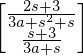

In [7]:
a = sympy.symbols('a')
tf = sympy.Matrix([
    TransferFunction([2, 3], [1, 1, 3*a]),
    TransferFunction([1, 3], [1, 3*a])])
tf

In [8]:
ss1 = tf2ss(tf)
ss1

StateSpace(
A=Matrix([
[sqrt(-12*a + 1)/2 - 1/2,                        0,    0],
[                      0, -sqrt(-12*a + 1)/2 - 1/2,    0],
[                      0,                        0, -3*a]]),
B=Matrix([
[1],
[1],
[1]]),
C=Matrix([
[(sqrt(-12*a + 1) + 2)/sqrt(-12*a + 1), (sqrt(-12*a + 1) - 2)/sqrt(-12*a + 1),        0],
[                                    0,                                     0, -3*a + 3]]),
D=Matrix([
[0],
[1]]),
dt=0)
        

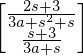

In [9]:
ss2tf(ss1)

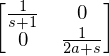

In [10]:
ss = StateSpace([[-1, 0], [0, -2*a]], sympy.eye(2), sympy.eye(2), sympy.zeros(2), 0)
G = ss2tf(ss)
G

In [11]:
ss = tf2ss(G)
ss

StateSpace(
A=Matrix([
[-1,    0],
[ 0, -2*a]]),
B=Matrix([
[1, 0],
[0, 1]]),
C=Matrix([
[1, 0],
[0, 1]]),
D=Matrix([
[0, 0],
[0, 0]]),
dt=0)
        

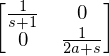

In [12]:
ss2tf(ss)

In [13]:
ssJ, T = jordan_canonical_form(ss)
ssJ

StateSpace(
A=Matrix([
[-1,    0],
[ 0, -2*a]]),
B=Matrix([
[1, 0],
[0, 1]]),
C=Matrix([
[1, 0],
[0, 1]]),
D=Matrix([
[0, 0],
[0, 0]]),
dt=0)
        

In [14]:
def ctrb(ss, n=ss.A.shape[0]):
    O_ctrb = ss.B
    for i in range(n-1):
        O_ctrb = O_ctrb.row_join(ss.A**n*ss.B)
    return O_ctrb

In [15]:
def obsvb(ss, n=ss.A.shape[0]):
    O_ctrb = ss.C
    for i in range(n-1):
        O_ctrb = O_ctrb.row_join(ss.C*ss.A**n)
    return O_ctrb

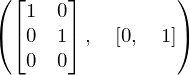

In [16]:
ctrb(ss1).rref()

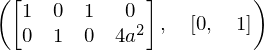

In [17]:
obsvb(ssJ).rref()